In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# CIFAR-10 normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Separate cats and dogs (classes 3 and 5)
cats_dogs_train = Subset(train_dataset, [i for i, (_, label) in enumerate(train_dataset) if label in [3, 5]])
cats_dogs_test = Subset(test_dataset, [i for i, (_, label) in enumerate(test_dataset) if label in [3, 5]])

# Separate other classes for autoencoder training
other_classes_train = Subset(train_dataset, [i for i, (_, label) in enumerate(train_dataset) if label not in [3, 5]])

# Data loaders
batch_size = 64
train_loader_cats_dogs = DataLoader(cats_dogs_train, batch_size=batch_size, shuffle=True)
test_loader_cats_dogs = DataLoader(cats_dogs_test, batch_size=batch_size, shuffle=False)
train_loader_other = DataLoader(other_classes_train, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:37<00:00, 4584505.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

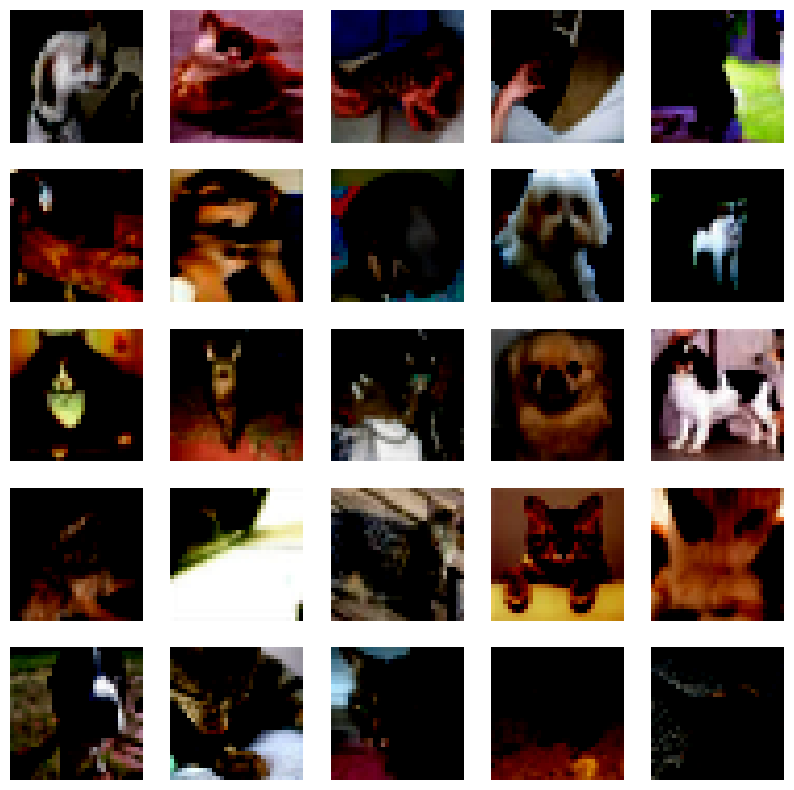

In [7]:
plt.figure(figsize=(10, 10))

for images, _ in train_loader_cats_dogs:
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.axis('off')
    break

In [5]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize and train the CNN
cnn = BasicCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

# Training loop
def train_model(model, loader, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in loader:
            labels = (labels == 3).long()  # Convert to binary classification (3 = cat, 5 = dog)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(loader)}")

# Train the CNN
train_model(cnn, train_loader_cats_dogs, epochs=30)


Epoch 1/30, Loss: 0.6424908588646324
Epoch 2/30, Loss: 0.5661853415191553
Epoch 3/30, Loss: 0.5235763926794574
Epoch 4/30, Loss: 0.48807538277024676
Epoch 5/30, Loss: 0.4590873475287371
Epoch 6/30, Loss: 0.4230886069452687
Epoch 7/30, Loss: 0.3990860928775399
Epoch 8/30, Loss: 0.3646636519842087
Epoch 9/30, Loss: 0.3247948412302953
Epoch 10/30, Loss: 0.29385345699680837
Epoch 11/30, Loss: 0.2538367408760794
Epoch 12/30, Loss: 0.21396495824217038
Epoch 13/30, Loss: 0.18464774211311036
Epoch 14/30, Loss: 0.1455756916551833
Epoch 15/30, Loss: 0.11014897736963952
Epoch 16/30, Loss: 0.08503226067420024
Epoch 17/30, Loss: 0.05817550729817835
Epoch 18/30, Loss: 0.04800154580171131
Epoch 19/30, Loss: 0.026094354122616112
Epoch 20/30, Loss: 0.017927399670384873
Epoch 21/30, Loss: 0.02447354342717274
Epoch 22/30, Loss: 0.020140621719205644
Epoch 23/30, Loss: 0.015856999805297964
Epoch 24/30, Loss: 0.03692161811480097
Epoch 25/30, Loss: 0.05058159546446126
Epoch 26/30, Loss: 0.020001937943706468


In [9]:
# save the model completely
torch.save(cnn, 'cnn.pth')

In [10]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the autoencoder
autoencoder = DenoisingAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
def train_autoencoder(model, loader, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, _ in loader:
            noisy_inputs = inputs + torch.randn_like(inputs) * 0.1
            noisy_inputs = torch.clip(noisy_inputs, 0., 1.)
            optimizer.zero_grad()
            outputs = model(noisy_inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(loader)}")

# Train the autoencoder
train_autoencoder(autoencoder, train_loader_other, epochs=30)

Epoch 1/30, Loss: 0.17944926671981812
Epoch 2/30, Loss: 0.14561788445711135
Epoch 3/30, Loss: 0.1443016310930252
Epoch 4/30, Loss: 0.14358117041587828
Epoch 5/30, Loss: 0.1430711734890938
Epoch 6/30, Loss: 0.14270757853984833
Epoch 7/30, Loss: 0.14241700868606566
Epoch 8/30, Loss: 0.14218357741832732
Epoch 9/30, Loss: 0.1419928953051567
Epoch 10/30, Loss: 0.14183114229440688
Epoch 11/30, Loss: 0.14170164014101028
Epoch 12/30, Loss: 0.14158489561080934
Epoch 13/30, Loss: 0.14148468763828279
Epoch 14/30, Loss: 0.14140199151039123
Epoch 15/30, Loss: 0.1413281719684601
Epoch 16/30, Loss: 0.14126624896526338
Epoch 17/30, Loss: 0.14120450221300127
Epoch 18/30, Loss: 0.14116002032756805
Epoch 19/30, Loss: 0.14111652891635895
Epoch 20/30, Loss: 0.14107155178785324
Epoch 21/30, Loss: 0.1410321895003319
Epoch 22/30, Loss: 0.14099803160429
Epoch 23/30, Loss: 0.14096825289726259
Epoch 24/30, Loss: 0.14094050664901733
Epoch 25/30, Loss: 0.1409117477297783
Epoch 26/30, Loss: 0.14089248472452165
Epoc

In [11]:
torch.save(autoencoder, 'autoencoder.pth')

In [12]:
class FineTuneModel(nn.Module):
    def __init__(self, encoder):
        super(FineTuneModel, self).__init__()
        self.encoder = encoder
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.fc_layers(x)
        return x

# Initialize fine-tune model with pre-trained encoder
fine_tune_model = FineTuneModel(autoencoder.encoder)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fine_tune_model.parameters(), lr=0.001)

# Fine-tune the model
train_model(fine_tune_model, train_loader_cats_dogs, epochs=30)

Epoch 1/30, Loss: 0.8590449166905348
Epoch 2/30, Loss: 0.6665546582762603
Epoch 3/30, Loss: 0.6348738723499759
Epoch 4/30, Loss: 0.6087976418862677
Epoch 5/30, Loss: 0.5758313153200089
Epoch 6/30, Loss: 0.5521178313880969
Epoch 7/30, Loss: 0.5288360872466094
Epoch 8/30, Loss: 0.5074914902638478
Epoch 9/30, Loss: 0.47607735862397843
Epoch 10/30, Loss: 0.4717172543714001
Epoch 11/30, Loss: 0.4408477011379922
Epoch 12/30, Loss: 0.4203259706687016
Epoch 13/30, Loss: 0.4107401602587123
Epoch 14/30, Loss: 0.39122444675986173
Epoch 15/30, Loss: 0.37629984290736496
Epoch 16/30, Loss: 0.34655201938121943
Epoch 17/30, Loss: 0.33452748274727234
Epoch 18/30, Loss: 0.32204929696526496
Epoch 19/30, Loss: 0.3058125723129625
Epoch 20/30, Loss: 0.28879118449748703
Epoch 21/30, Loss: 0.2793258750324796
Epoch 22/30, Loss: 0.262800152419479
Epoch 23/30, Loss: 0.2468772797258037
Epoch 24/30, Loss: 0.24151044865702367
Epoch 25/30, Loss: 0.21859424233816233
Epoch 26/30, Loss: 0.22161787231067184
Epoch 27/30,

In [13]:
torch.save(autoencoder, 'autoencoder.pth')